# Plotting Test with Julia

Here are some instructions about plotting in Julia https://docs.juliaplots.org/latest/tutorial

## The Homogeneous sphere

The homogeneous sphere model is based on the paper by [Band and Grindlay (1985)](https://ui.adsabs.harvard.edu/abs/1985ApJ...298..128B/abstract). We'll refer to this paper as BG85.

In the homogeneous source the magnetic field is constant over the sphere and is parameterized by:

$n_{e0}$ : The normalization of the electron density

$\gamma_{min}$ and $\gamma_{max}$ : The range of electron Lorentz factors

$p$ : The spectral index of the electrons

$B_0$ : The magnetic field strength

$r$ : The size of the Blob

### Electron distribution

The differential electron density is given by Equation II.1 in BG85 $$dn_e = n_{e0} \gamma^{-p} d\gamma$$ where $\gamma_{min} \leqslant \gamma \leqslant \gamma_{max}$.

The electron density is then $$n_e = n_{e0} \int_{\gamma_{min}}^{\gamma_{max}} \gamma^{-p} d\gamma.$$

Fergus recommended the [HCubature](https://github.com/JuliaMath/HCubature.jl) integrator. This is written natively in Julia and is actively maintained.

In [1]:
# Package needed to calculate the integration

using HCubature

I don't think we need to use the following at the moment (which integrates the electron density to get the total density). But we might need it later?

In [ ]:
# Generating function to calculate electron distribution (I have not yet tested this part)

function elec_dis(n_e0, gamma_min, gamma_max, )
    using NIntegration
    gamma_func = gamma**(-p)
    dn_e = n_e0*nintegrate(gamma_func, gamma_min, gamma_max)
end

In [9]:
"""
    n_e(gamma, n_e0, p, gamma_min, gamma_max)

Evaluates the electron density at Lotentz factor `gamma`
assuming a power law distribution of Lorentz factors
from `gamma_min` to `gamma_max` with a power law index `p`
"""

function n_e(gamma, n_e0, p, gamma_min, gamma_max)
    if (gamma < gamma_min) || (gamma > gamma_max)
        n_e = 0.0
    else
        n_e = n_e0 * gamma^-p
    end
    return n_e
end

n_e (generic function with 1 method)

### Comoving volume synchrotron emissivity

For an isotropic electron distribution in a randomly oriented magnetic field, the synchrotron emissivity is (see [Dermer et al. (1997)](https://ui.adsabs.harvard.edu/abs/1997ApJS..109..103D/abstract) equation 13; we've changed their $H$ to our $B$)

$$j_\text{syn}(\epsilon, \Omega; x) = \frac{c \sigma_{T} u_{B}}{6 \pi \epsilon_B} \left(\frac{\epsilon}{\epsilon_B}\right)^{\tiny{1/2}} \small{n_e} \left[\left(\frac{\epsilon}{\epsilon_B}\right)^{\tiny{1/2}};x \right]$$

where $u_B \equiv {B^2}/{8\pi}$ is the energy density of the magnetic field with strength $B \equiv 4.414 \times 10^{13} \epsilon_B$ G

$\epsilon \equiv h\nu/m_ec^2$ is the dimensionless photon energy in units of the electron rest mass energy

$c$ : The speed of light

$\sigma_T$ : The Thomson cross-section

$\epsilon_B$ : The cyclotron energy in units of ${m_e c^2}$

$n_e \left( \gamma , \Omega ; x \right)$ : The differential electron density ($\text{electrons} \, \text{cm}^{-3} \, \gamma^{-1} \, \text{sr}^{-1}$) at location $x$ (cm)

$\Omega = \left( \mu, \phi \right)$ : Photon direction specified by direction cosine ${\mu}$ and azimuthal angle ${\phi}$

$h$ : Planck's constant

$m_e$ : The mass of electrons

In [37]:
# Package needed to run the code

#using Random
using LaTeXStrings
using Plots
gr()

Plots.GRBackend()

I'm not sure we need an `x` array to start with. We can consider the synchrotron emissivity from a single point to start with, e.g., $x \equiv 0$.

In [ ]:
# Define the x array (Here I just generate sequence of 500 numbers, value of x to be decided)

x = [1:1:500;]               #x : Location of the blob
length(x)

Note that I've changed the units to cgs units for consistency with the literature rather than SI units. I've taken these from the [Handbook of Space Astronomy and Astrophysics](https://ads.harvard.edu/books/hsaa/), specifically the section on [Fundamental physical constants (c.g.s.)](https://ads.harvard.edu/cgi-bin/bbrowse?book=hsaa&page=10).

Please check I've transcribed the values correctly!

We'd like to plot the emissivity as a function of frequency so I've commented out the specific value suggested below.

Changed $H \rightarrow B$. Prefer $B$ for the magnetic field in material with little or no magnetism.

For testing of the code chosen some arbitrary parameters that seem reasonable for a synchrotron emitting hot spot (although they could easily be different my several orders of magnitude!)

$$
B = 3.0 \times 10^{-6} \, \text{G} \\
n_{e_0} = 500.0\, \text{cm}^{-3} \\
p = 3.0
$$

Reordered the code slightly so we go from the field to the cyclotron energy.

The "cyclotron energy" is related to the quantum critical field $B_\text{cr} = m_e^2 c^3 / e \hbar = 4.414 \times 10^{13} \, \text{G}$, i.e., that for which the electron cyclotron and electron rest mass energies are equal. (Need to check / research this more!)

$\gamma_\text{min}$ and $\gamma_\text{max}$ are set to arbitrary values.

In [28]:
# Define all the parameters (Units conversion to be done later)

m_e = 9.1093897E-28         # m_e : electron mass in g
c = 2.99792458E10           # c : speed of light in cm s^-1
h = 6.6260755E-27           # h : Planck's constant in ergs

sigma_T = 0.66524616E-24    # sigma_T : Thomson cross-section in cm^2
#nu = 10^16                 # nu : Photon frequency in Hz (Value TBD)

B = 3.0E-6                  # B : magnetic field strength in Gauss
epsilon_B = B/4.14E13       # epsilon_B : cyclotron energy in units of m_e*c^2
u_B = B^2/8.0*pi            # u_B : magnetic field energy density

n_e0 = 500.0                # n_e0 : normalisation of electron density
p = 3.0                     # p : power law index of electron distribution function
gamma_min = 1.0E2           # gamma_min : minimum Lorentz factor of electrons
gamma_max = 1.0E7           # gamma_max : maximum Lorentz factor of electrons

#epsilon = (h*nu)/(m_e*c^2) # epsilon : photon energy density in units of the electron rest mass energy

# Generate the n_e value (This still need to be studied)
# Here I just generate 500 random number
#ne = MersenneTwister(1234)
#n_e = randexp!(ne, zeros(500));  #n_e : differential electron density (electrons cm-3 gamma-1 sr-1) at location x (cm)

We'd like to plot $j_\text{syn}$ as a function of $\nu$.

Need to convert from photon frequency $\nu$ to an electron lorentz factor $\gamma$. This must be related to the $\delta$-function approximation referred to in the text just before equation 13 in the Dermer et al. (1997) paper and is apparently calculated in [Dermer & Schlickeiser (1993)](https://ui.adsabs.harvard.edu/abs/1993ApJ...416..458D/abstract).

In [42]:
# Set up an array of photon frequencies
log_nu_low = 9.0                                    # log_10 low frequency 
log_nu_high = 19.0                                  # log_10 high frequency
# create log frequency array
log_nu = range(log_nu_low, stop=log_nu_high, length=100)

# Define the j_syn array as function of frequency

j_syn = zeros(length(log_nu))                       # j_syn : synchrotron emissivity in ergs cm-3 s-1 sr-1 epsilon-1

# Calculate j_syn
# The equation looks like below but I wonder if we still have to integrate it 
# as J_sync is in function of the photon energy epsilon, photon direction Omega and the location x.

for i in eachindex(j_syn)
    nu = 10.0^log_nu[i]
    # need to convert photon frequency to epsilon
    epsilon = h*nu/(m_e*c^2)
    # need to convert photon frequency to characteristic lorentz factor gamma
    gamma = sqrt(epsilon / epsilon_B) # <-- *** this needs to be checked and understood - might be wrong! ***

    # print("gamma = ", gamma, " and epsilon = ", epsilon, " and epsilon_B = ", epsilon_B, "\n")

    j_syn[i] = ((c*sigma_T*u_B)/(6.0*pi*epsilon_B)) * sqrt(epsilon/epsilon_B) * n_e(gamma, n_e0, p, gamma_min, gamma_max)
end

# println(j_syn)

┌ Warning: Invalid negative or zero value 0.0 found at series index 60 for log10 based yscale
└ @ Plots /Users/ayoung/.julia/packages/Plots/NQpB8/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 60 for log10 based yscale
└ @ Plots /Users/ayoung/.julia/packages/Plots/NQpB8/src/utils.jl:95


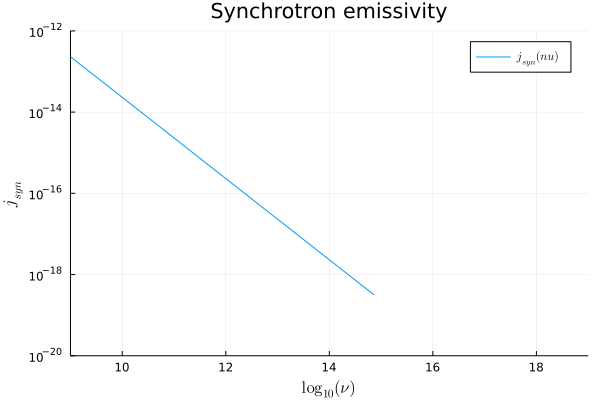

┌ Warning: Invalid negative or zero value 0.0 found at series index 60 for log10 based yscale
└ @ Plots /Users/ayoung/.julia/packages/Plots/NQpB8/src/utils.jl:95


In [43]:
# Plotting the synchrotron emissivity
# The feature of the plot below may not be the required feature for the synchrotron emissivity
# But I just tested how to plot with Julia
# Values of some parameters still need to be fixed

plot(log_nu, j_syn, label = L"j_{syn} (nu)", title = "Synchrotron emissivity", yaxis=:log10, xlims=(9, 19), ylims=(1.0E-20, 1.0E-12))
xlabel!(L"\log_{10} (\nu)")
ylabel!(L"j_{syn}")